# Active-Reinforcement Learning

In [1]:
import torch
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import torch.nn as nn
from copy import deepcopy
import time
import torch.nn.functional as F
import sys

device = "cuda:1"

# c = np.random.randn(3,2)
# c=np.clip(a_min=-2.0,a_max=2.0,a=c)
def labels(x,c):
    
    d=c-x
    d=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    
    for i in d:
        if i[0]==0 and i[1]==0:
             return(1)
    else: return(0.2)
    
def labels_diff_shape(x,c):
    
    d=c-x
    d1=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    d1_prox = []
    d2=np.clip(a_min=-0.5,a_max=0.9,a=d)-d
    d2_prox = []

    for i in d1:
        if i[0]==0 and i[1]==0:
             d1_prox.append(1)
        else: d1_prox.append(0)
    for i in d2:
        if i[0]==0 and i[1]==0:
             d2_prox.append(1)
        else: d2_prox.append(0)

    if (d1_prox[0]==1 and d2_prox[0]==1) or (d1_prox[1]==1) or (d2_prox[0]==1):
        return(1)
    else: return(0.2)  
    

## Create True Maps

In [2]:
import numpy as np

X_MIN, X_MAX, Y_MIN, Y_MAX = -2.5, 2.5, -2.5, 2.5
TABLE_X_LENGTH, TABLE_Y_LENGTH = 1, 1
SOFA_X_LENGTH, SOFA_Y_LENGTH = 1, 1
map_scale = 32

def random_table_sofa_centers(n_tables, n_sofas):
    """
    Generate random table center locations within the bounds of the room and not
    overlapping with each other.

    :param n_tables: The number of table centers to generate
    :return: The table centers in a list of [x, y] pairs
    """
    def is_overlap(table_centers, sofa_centers, new_x, new_y, new_x_len, new_y_len):
        overlap = False
        for x, y in table_centers:
            if (abs(x - new_x) < (TABLE_X_LENGTH + new_x_len) / 2 and 
                abs(y - new_y) < (TABLE_Y_LENGTH + new_y_len) / 2):
                overlap = True
        for x, y in sofa_centers:
            if (abs(x - new_x) < (SOFA_X_LENGTH + new_x_len) / 2 and 
                abs(y - new_y) < (SOFA_Y_LENGTH + new_y_len) / 2):
                overlap = True
        return overlap

    table_centers, sofa_centers = [], []
    for _ in range(n_tables):
        new_x = X_MIN + TABLE_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - TABLE_X_LENGTH)
        new_y = Y_MIN + TABLE_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - TABLE_Y_LENGTH)
        while is_overlap(table_centers, sofa_centers, new_x, new_y, TABLE_X_LENGTH, TABLE_Y_LENGTH):
            new_x = X_MIN + TABLE_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - TABLE_X_LENGTH)
            new_y = Y_MIN + TABLE_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - TABLE_Y_LENGTH)
        table_centers.append([new_x, new_y])
    for _ in range(n_sofas):
        new_x = X_MIN + SOFA_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - SOFA_X_LENGTH)
        new_y = Y_MIN + SOFA_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - SOFA_Y_LENGTH)
        while is_overlap(table_centers, sofa_centers, new_x, new_y, SOFA_X_LENGTH, SOFA_Y_LENGTH):
            new_x = X_MIN + SOFA_X_LENGTH / 2 + np.random.rand() * (X_MAX - X_MIN - SOFA_X_LENGTH)
            new_y = Y_MIN + SOFA_Y_LENGTH / 2 + np.random.rand() * (Y_MAX - Y_MIN - SOFA_Y_LENGTH)
        sofa_centers.append([new_x, new_y])
    return table_centers, sofa_centers
room_center=[]
for i in range(200):
    temp = random_table_sofa_centers(5,0)
    room_center.append(temp[0])
c_rooms = np.stack(room_center)

## Create Images for input
### Using ground truth

# Centers

In [3]:
xc=np.random.randint(low=-150,high=150,size=(200,30,2))

In [4]:
# from labeller
# imgs_in=[]
# for i,room in enumerate(xc):
#     temp = []
#     for j in room:
#         temp_img=[]
#         temp_x = np.arange(j[0]-100,j[0]+100,5)
#         temp_y = np.arange(j[1]-100,j[1]+100,5)
#         x,y=np.meshgrid(temp_x,temp_y)
#         for k in np.append(x.reshape(1,1600).T,y.reshape(1,1600).T,1):
#             temp_img.append(labels(k/100,c_rooms[i]))
#         temp_img=np.array(temp_img)
#         temp.append(temp_img.reshape(40,40))
#     imgs_in.append(temp)
    
        

In [5]:
def inp_image_from_truth(true_map,xy):
    xy[0]+=2.5
    xy[1]+=2.5
    xy[0]/=0.05
    xy[1]/=0.05  
    a = np.int(np.floor(xy[0]))
    b = np.int(np.floor(xy[1]))
    return(true_map[a-20:a+20,b-20:b+20])

### Create Padded input images

#### For GVM

In [6]:
def pad_images(image,xy):
    c_x = xy[0]/0.05+50
    c_y = xy[1]/0.05+50
    x_0 =int(c_x%10)
    y_0 = int(c_y%10)
    image_new = np.zeros((2,50,50))
    image_new[0,x_0:x_0+40,y_0:y_0+40] = 1
    image_new[1,x_0:x_0+40,y_0:y_0+40] = image
    return(image_new)
    

#### For LSTM-CNN

In [7]:
def pad_images_LSTM(image,xy):
    c_x = xy[0]/0.05+50
    c_y = xy[1]/0.05+50
    x_0 = int(c_x//10)*10
    y_0 = int(c_y//10)*10
    
    image_new = np.zeros((2,100,100))
    image_new[0,x_0-20:x_0+30,y_0-20:y_0+30] = image[0]
    image_new[1,x_0-20:x_0+30,y_0-20:y_0+30] = image[1]
    return(image_new)
    

## Create True Map

In [8]:
def create_true_map(centres):
    #select uniformly
    xm=np.arange(-2.5,2.5,0.05)
    ym=np.arange(-2.5,2.5,0.05)
    xm,ym = np.meshgrid(xm,ym)
    map_samp = np.append(xm.reshape(1,10000).T,ym.reshape(1,10000).T,1)
    #label Uniform Points
    true_map = []
    for j in range(10000):
        true_map.append(labels(map_samp[j],centres))
    return(np.array(true_map).reshape(100,100))

In [9]:
true_maps = []
for i in c_rooms:
    true_maps.append(create_true_map(i))

In [10]:
imgs_in=[]
for i,room in enumerate(xc):
    temp = []
    for j in room:
        temp_img=inp_image_from_truth(true_maps[i],j/100)
        temp.append(temp_img)
    imgs_in.append(temp)

## Plot True Maps

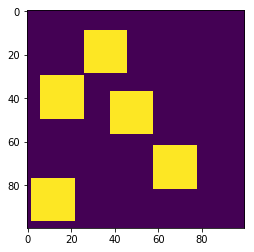

In [11]:
plt.imshow(true_maps[0])

# pad input data

In [12]:
imgs_in_1 = deepcopy(imgs_in)
imgs_in_2 = deepcopy(imgs_in)
for rooms in range(200):
    for j,image in enumerate(imgs_in[rooms]):
        image = pad_images(image,xc[rooms][j]/100)
        imgs_in_1[rooms][j] = image
        imgs_in_2[rooms][j] = pad_images_LSTM(image,xc[rooms][j]/100)


In [13]:
t=(int((xc[0][0][0]/5+50)//10)*10,int((xc[0][0][1]/5+50)//10)*10)

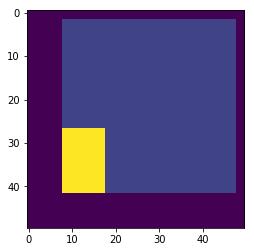

In [14]:
plt.imshow(imgs_in_1[0][0][1])

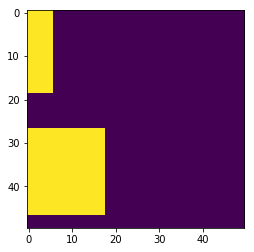

In [15]:
plt.imshow(true_maps[0][t[0]-20:t[0]+30,t[1]-20:t[1]+30])

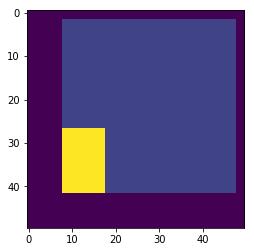

In [16]:
plt.imshow(imgs_in_2[0][0][1][t[0]-20:t[0]+30,t[1]-20:t[1]+30])

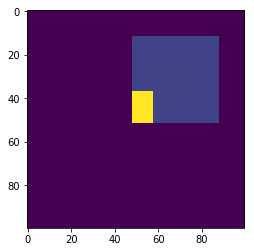

In [ ]:
plt.imshow(imgs_in_2[0][0][1])

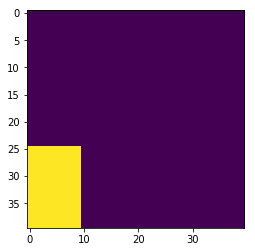

In [ ]:
plt.imshow(imgs_in[0][0])

In [ ]:
def tensor(obj):
    return torch.tensor(obj, device=device,dtype = torch.float)

# Conv_LSTM

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        self.features = nn.Sequential(  # 100x100
            nn.Conv2d(2, 8, 5),  # 96x96
            nn.ReLU(True),
            nn.MaxPool2d(2),  # 48x48
            nn.Conv2d(8, 16, 7),  # 42x42
            nn.ReLU(True),
            nn.MaxPool2d(3),  # 14x14
            nn.Conv2d(16, 16, 5),  # 10x10
        )
        self.conv = nn.Sequential(nn.Conv2d(in_channels=self.hidden_dim + self.input_dim,
                              out_channels=36,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias),
                                    nn.Conv2d(in_channels=36,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias))

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        combined = torch.cat([self.features(input_tensor), h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        
#         return (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda(),
#                 Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda())
        temp = (tensor(Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width))),
                tensor(Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width))))
        return temp

class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size
        device = "cuda:1"
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias).to(device))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))
        layer_output_list = []
        layer_output_list = []
        last_state_list   = []
        layer_output_inner_list = []
        layer_output_outer_list = []
        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            output_outer = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)
                output_outer.append(c)
            cur_layer_input = torch.stack(output_inner, dim=1)
            
            layer_outer = torch.stack(output_outer, dim=1)
            layer_output_inner = torch.stack(output_inner, dim=1)
            layer_output_inner_list.append(cur_layer_input)
            layer_output_outer_list.append(layer_outer)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_inner_list,layer_output_outer_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
height = 10
width = 10
channels = 16

model = ConvLSTM(input_size=(height, width),
                 input_dim=channels,
                 hidden_dim=[10],
                 kernel_size=(3, 3),
                 num_layers=1,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)
model.to(device)

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (features): Sequential(
        (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
      )
      (conv): Sequential(
        (0): Conv2d(26, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(36, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)

In [ ]:
tensor(np.stack(imgs_in_2)).shape

torch.Size([200, 30, 2, 100, 100])

In [ ]:
model.to(device)

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (features): Sequential(
        (0): Conv2d(2, 8, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
      )
      (conv): Sequential(
        (0): Conv2d(26, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(36, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)

In [ ]:
(model(tensor(np.stack(imgs_in_2))[0].unsqueeze(0))[0][0]).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([1, 30, 10, 10, 10])

In [ ]:
class LSTM_Decoder(nn.Module):
    def __init__(self):
        super(LSTM_Decoder, self).__init__()
        self.map_decoder = nn.Sequential(
            nn.ConvTranspose2d(20, 16, 5, stride=3, padding=2),  # b, 16, 28, 28
            nn.ReLU(True),
            nn.Dropout(0.1),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=2),  # b, 8, 53, 53
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=3)  # b, 1, 100, 100
        ) 
        self.optimizer = torch.optim.Adam(self.parameters(),weight_decay = 0.0001,  lr=0.001)
        self.sm = nn.Softmax(dim=1)
    def forward_map_decode(self, grid_mem):
        scores = self.map_decoder(grid_mem)
        return torch.cat((scores, -scores), 1)
            
    
    def train_K_decoder(self,model, imgs_in, xy_in, label_maps, K=150, min_seq_len=1, max_seq_len=10, 
                         max_epochs=200, holdout=0, outfile=None):
        print("starting training on prev")
        start = time.time()
        rooms = range(K)
        bs = 128
        curr_hist = []
        acc_hist = []

        room_data = []
        for r in rooms:
            for seq_len in range(10,11):# range(min_seq_len, min(max_seq_len + 1, imgs_in[r].shape[0])):
                room_data.append([r, seq_len])
        room_data = np.array(room_data, dtype=int)
        np.random.shuffle(room_data)
        room_data = room_data[:int(len(room_data) * (1 - holdout))]

        print('total training data points: ', len(room_data))
        for epoch in range(max_epochs):
            if epoch % 100 == 99 and outfile:
                torch.save(self.state_dict(), outfile + str(epoch+1) + 'ep.pth')
            self.train()           
            np.random.shuffle(room_data)

            seq_images = []
            j = 0
            for r, seq_len in room_data:
                #if j==0: print(r, seq_len, pred_idx)
                element_idxs = np.random.choice(30, 
                                                seq_len, replace=False)
                seq_images = imgs_in[r][element_idxs]

                seq_xy = xy_in[r][element_idxs]

    #unsqueezes state,forward expects map,grid_mem initialized without batch axis    
                h,c,_ = model(seq_images.unsqueeze(0))
    #                 print(temp.shape)
                pred = self.forward_map_decode(torch.cat((h[0],c[0]),2).squeeze(0))
                loss_function = nn.CrossEntropyLoss()#weight=tensor([.25, 1.5]))
                
                self.optimizer.zero_grad()

#                 pred = self.forward_2_batch(self.embedding, xy_list)
                temp = self.sm(pred)[:,1]>0.5 #1x108x108

                correct = (temp[:][0].long() == torch.stack([label_maps[r]]*seq_len)) 
                acc = (float(torch.sum(correct))/(correct.shape[0] * correct.shape[1]))
#                 loss = loss_function(pred, label_maps[r].unsqueeze(0))  # torch.tensor(1,dtype = torch.long))

#                 loss.backward(retain_graph=True)
                loss = loss_function(pred,torch.stack([label_maps[r]]*seq_len))
                loss.backward(retain_graph=True)
                self.optimizer.step()
                curr_hist.append(float(loss.data))
                acc_hist.append(acc)
                j += 1
                if j % 1000 == 0:
                     print(curr_hist[-1], acc)
            
            if epoch % 1 == 0:
                vl, va = validate(self,model, range(10, 10+1))
                print('\r epoch %d : trainloss %.4f  trainacc %.4f  valloss %.4f  valacc %.4f  time %.2f' % (epoch + 1, np.mean(curr_hist), np.mean(acc_hist), vl, va, time.time() - start))
            
            #print(np.mean(curr_hist))
                hist.append(np.mean(curr_hist))
                val_hist.append(vl)
                curr_hist = []
                acc_hist = []
                

# Test

In [ ]:
def validate(decoder,model, seq_range, reps=5):
        room_data = []
        rooms = range(150, 200)
        for r in rooms:
            for seq_len in seq_range:
                room_data.append([r, seq_len])
        losses = []
        accs = []  
        for _ in range(reps):
            #print(_)
            model.eval()
            np.random.shuffle(room_data)

            for r, seq_len in room_data:
                #if j==0: print(r, seq_len, pred_idx)
                element_idxs = np.random.choice(range(30), 
                                                seq_len, replace=False)
                seq_images = tensor(np.stack(imgs_in_2)[r][element_idxs])
                aug_xy = np.array(xc)/100
                seq_xy = aug_xy[r][element_idxs]
                
                h,c,_ = model(seq_images.unsqueeze(0))
                pred = decoder.forward_map_decode(torch.cat((h[0],c[0]),2).squeeze(0))
                loss_function = nn.CrossEntropyLoss()
                
                pred_class = decoder.sm(pred)[:,1]>0.5
                #print(pred_class.shape)
                coarse_maps = torch.tensor(true_maps,dtype = torch.long,device = device)
                correct = (pred_class[:][0].long() == torch.stack([coarse_maps[r]]*seq_len)) 
                acc = (float(torch.sum(correct))/(correct.shape[0] * correct.shape[1]))

                loss = loss_function(pred, torch.stack([coarse_maps[r]]*seq_len))  # torch.tensor(1,dtype = torch.long))
                accs.append(acc)
                losses.append(float(loss.data))
        return np.mean(losses), np.mean(accs)

In [ ]:
hist = []
val_hist = []

In [ ]:
A=LSTM_Decoder()
A.to(device)

LSTM_Decoder(
  (map_decoder): Sequential(
    (0): ConvTranspose2d(20, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(3, 3))
  )
  (sm): Softmax(dim=1)
)

In [ ]:
A.train_K_decoder(model,tensor(np.stack(imgs_in_2)),xc/100,torch.tensor(np.stack(true_maps),dtype = torch.long,device=device))
torch.save(A.state_dict(), '/home/azav/cn_lstm')

starting training on prev
total training data points:  150


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
seq_images=tensor(np.stack(imgs_in_2[15][0:10]))

In [ ]:
h,c,_ = model(seq_images.unsqueeze(0))
pred = A.forward_map_decode(torch.cat((h[0],c[0]),2).squeeze(0))

In [ ]:
torch.save(model.state_dict(), '/home/azav/cn_lstm_100b')

In [ ]:
prediction=(A.sm(pred)[:,1]>0.5).detach().cpu().numpy()

In [ ]:
prediction.shape

In [ ]:
plt.imshow(prediction[9]*1)